In [20]:
import pandas as pd
import numpy as np 
from datetime import date
import quandl
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential

Using TensorFlow backend.
/Users/zhaozeyuan/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/zhaozeyuan/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/zhaozeyuan/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/zhaozeyuan/anaconda3/lib/python3.7

In [38]:
start = date(2000,10,12)
end = date.today()
google_stock = pd.DataFrame(quandl.get("WIKI/GOOGL", start_date=start, end_date=end))
print(google_stock.shape)
google_stock.tail()
google_stock.head()

(813, 12)


,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2015-01-02,222.87,223.2500,213.2600,219.310,4764443.0,0.0,1.0,222.87,223.2500,213.2600,219.310,4764443.0
2015-01-05,214.55,216.5000,207.1626,210.090,5368477.0,0.0,1.0,214.55,216.5000,207.1626,210.090,5368477.0
2015-01-06,210.06,214.2000,204.2100,211.280,6261936.0,0.0,1.0,210.06,214.2000,204.2100,211.280,6261936.0
2015-01-07,213.35,214.7800,209.7800,210.950,2968390.0,0.0,1.0,213.35,214.7800,209.7800,210.950,2968390.0
2015-01-08,212.81,213.7999,210.0100,210.615,3442509.0,0.0,1.0,212.81,213.7999,210.0100,210.615,3442509.0


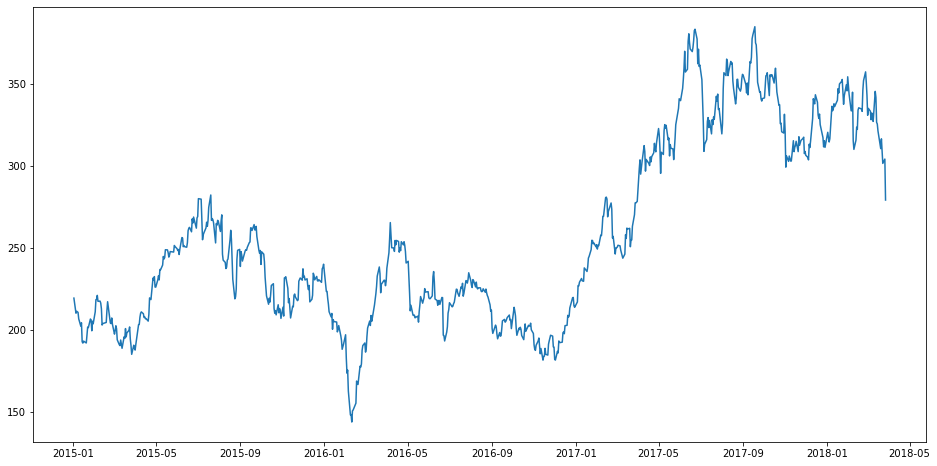

In [39]:
plt.figure(figsize=(16, 8))
plt.plot(google_stock['Close'])
plt.show()

In [40]:
# 时间点长度
time_stamp = 50


# 划分训练集与验证集
google_stock = google_stock[['Open', 'High', 'Low', 'Close', 'Volume']]  #  'Volume'
train = google_stock[0:2800 + time_stamp]
valid = google_stock[2800 - time_stamp:]


# 归一化
scaler = MinMaxScaler(feature_range=(0, 1))  
scaled_data = scaler.fit_transform(train)
x_train, y_train = [], []




# 训练集
print(scaled_data.shape)
print(scaled_data[1, 3])
for i in range(time_stamp, len(train)):
    x_train.append(scaled_data[i - time_stamp:i])
    y_train.append(scaled_data[i, 3])


x_train, y_train = np.array(x_train), np.array(y_train)


# 验证集
scaled_data = scaler.fit_transform(valid)
x_valid, y_valid = [], []
for i in range(time_stamp, len(valid)):
    x_valid.append(scaled_data[i - time_stamp:i])
    y_valid.append(scaled_data[i, 3])


x_valid, y_valid = np.array(x_valid), np.array(y_valid)


print(x_train.shape)
print(x_valid.shape)
train.head()

(813, 5)
0.27522479592259563


ValueError: Found array with 0 sample(s) (shape=(0, 5)) while a minimum of 1 is required by MinMaxScaler.

In [24]:
from keras.layers import LSTM
from keras.layers import Dense

# 超参数
epochs = 3
batch_size = 16
# LSTM 参数: return_sequences=True LSTM输出为一个序列。默认为False，输出一个值。
# input_dim：输入单个样本特征值的维度
# input_length：输入的时间点长度
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_dim=x_train.shape[-1], input_length=x_train.shape[1]))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

/Users/zhaozeyuan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # This is added back by InteractiveShellApp.init_path()
/Users/zhaozeyuan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=100, return_sequences=True, input_shape=(50, 5))`
  # This is added back by InteractiveShellApp.init_path()



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/3
2800/2800 [==============================] - 33s 12ms/step - loss: 0.0035
Epoch 2/3
2800/2800 [==============================] - 34s 12ms/step - loss: 7.2555e-04
Epoch 3/3
2800/2800 [==============================] - 41s 15ms/step - loss: 6.1367e-04


In [25]:
closing_price = model.predict(x_valid)
scaler.fit_transform(pd.DataFrame(valid['Close'].values))
# 反归一化
closing_price = scaler.inverse_transform(closing_price)
y_valid = scaler.inverse_transform([y_valid])
# print(y_valid)
# print(closing_price)
rms = np.sqrt(np.mean(np.power((y_valid - closing_price), 2)))
print(rms)
print(closing_price.shape)
print(y_valid.shape)

185.0452830130648
(624, 1)
(1, 624)


In [35]:
data_pd['Close'].head()

0    656.99
1    671.68
2    671.64
3    670.00
4    667.00
Name: Close, dtype: float64

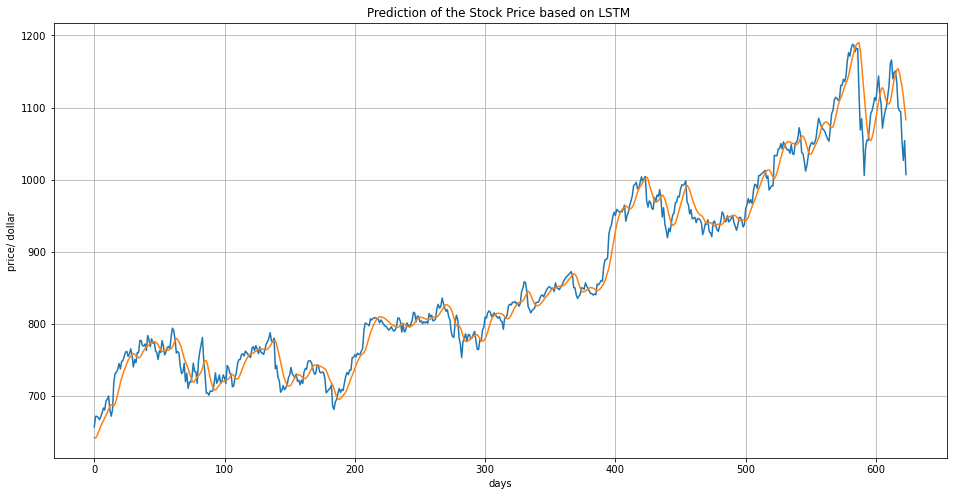

In [37]:
plt.figure(figsize=(16, 8))
dict_data = {
    'Predictions': closing_price.reshape(1,-1)[0],
    'Close': y_valid[0]
}
data_pd = pd.DataFrame(dict_data)

plt.plot(data_pd[['Close', 'Predictions']])
plt.xlabel('days')
plt.ylabel('price/ dollar')
# plt.legend([data_pd['Predictions'],data_pd['Close']], ['Predictions', 'RealPrice'], loc = 'upper left')    
plt.title('Prediction of the Stock Price based on LSTM ')
plt.grid()
plt.show()